In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import random

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
r = requests.get(url)
open('input.txt', 'wb').write(r.content)
!wc input.txt

  40000  202651 1115394 input.txt


In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(f'length of dataset in characters: {len(text)}')
print(text[:1000])

length of dataset in characters: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunge

In [ ]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(f'{vocab_size} unique characters')
print(f'vocab:{"".join(vocab)}')

stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join(itos[i] for i in l)

print(f'encode: {encode("hello!")}')
print(f'decode: {decode(encode("hello"))}')

65 unique characters
vocab:
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
encode: [46, 43, 50, 50, 53, 2]
decode: hello


In [ ]:
# tiktoken tokenizer
!pip install tiktoken
import tiktoken

enc = tiktoken.get_encoding('gpt2')
print(enc.n_vocab)
print(enc.encode('hello!'))
print(enc.decode([31373,0]))

In [ ]:
# data curation
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])
n = int(len(data)*0.9)

train_data = data[:n]
val_data = data[n:]

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [ ]:
block_size = 8
train_data[:block_size]

word = train_data[:block_size+1]
for i in range(block_size):
  print(word[:i+1].tolist(), '->', word[i+1].tolist())

[18] -> 47
[18, 47] -> 56
[18, 47, 56] -> 57
[18, 47, 56, 57] -> 58
[18, 47, 56, 57, 58] -> 1
[18, 47, 56, 57, 58, 1] -> 15
[18, 47, 56, 57, 58, 1, 15] -> 47
[18, 47, 56, 57, 58, 1, 15, 47] -> 58


In [ ]:
''' Transformer decoder

batch of tokens                               batch_size x block_size
-> token embedding   +  position embedding    batch_size x block_size x embed_size
-> blocks x num_layer
  -> multi head self attention
      projections Wqi, Wki, Wvi                 batch_size x block_size * head_size.  x num_heads
      softmax(Q@K.T)/sqrt(head_size) * mask)@V. batch_size x block_size * head_size
      concatenate                               batch_size x block_size * embed_size
      projection                                batch_size x block_size x embed_size

  -> add residual                               batch_size x block_size x embed_size
  -> layer norm                                 batch_size x block_size x embed_size

  -> feedforward
      projection                                batch_size x block_size x 4*embed_size
      relu
      projection                                batch_size x block_size x embed_size

  -> add residual                               batch_size x block_size x embed_size
  -> layer norm                                 batch_size x block_size x embed_size
-> Linear                                       batch_size x block_size x vocab_size
-> softmax                                      batch_size x block_size x vocab_size
'''

block_size = 8
embed_size = 64
num_heads = 4
head_size = embed_size // num_heads
num_layers = 4
batch_size = 64

# ln = torch.nn.LayerNorm(embed_size)
# bn = torch.nn.BatchNorm1d(block_size)
# data = torch.arange(batch_size*block_size*embed_size).float().view(batch_size, block_size, embed_size)
# print(ln(data)[0,0,:].mean(), bn(data)[:,0,0].mean())

class MultiHeadSelfAttention(torch.nn.Module):
  def __init__(self, block_size, embed_size, num_heads):
    super().__init__()
    self.block_size = block_size
    self.embed_size = embed_size
    self.num_heads = num_heads
    self.head_size = embed_size // num_heads
    self.register_buffer('mask',torch.tril(torch.ones(block_size, block_size))==0)

    # 3 x num_heads project weights of size embed_size x head_size
    self.wqs = torch.nn.ModuleList([torch.nn.Linear(self.embed_size, self.head_size, bias=False) for _ in range(num_heads)])
    self.wks = torch.nn.ModuleList([torch.nn.Linear(self.embed_size, self.head_size, bias=False) for _ in range(num_heads)])
    self.wvs = torch.nn.ModuleList([torch.nn.Linear(self.embed_size, self.head_size, bias=False) for _ in range(num_heads)])
    self.projection = torch.nn.Linear(self.embed_size, self.embed_size)

  def __call__(self, x):
    # mask
    # for each head: softmax(wq(x) @ wk(x).T / sqrt(head_size)) @ wv(x)
    # concat head outputs
    # projection
    heads_output = [
        F.softmax((wq(x) @ wk(x).transpose(-1,-2) / self.head_size**0.5)
                      .masked_fill(self.mask, float('-inf')), dim=-1) @ wv(x)
        for wq, wk, wv in zip(self.wqs, self.wks, self.wvs)]
    concat_output = torch.cat(heads_output, dim=-1)
    self.out = self.projection(concat_output)
    return self.out

  def parameters(self):
    return list(self.wqs.parameters()) + list(self.wks.parameters()) + \
      list(self.wvs.parameters()) + list(self.projection.parameters())

# test
mhsa = MultiHeadSelfAttention(block_size, embed_size, num_heads)
print(mhsa(torch.arange(batch_size*block_size*embed_size).float().view(batch_size, block_size, embed_size)).shape)

class Block(torch.nn.Module):
  def __init__(self, block_size, embed_size, num_heads):
    super().__init__()
    # mhsa
    self.mhsa = MultiHeadSelfAttention(block_size, embed_size, num_heads)
    self.ln1 = torch.nn.LayerNorm(embed_size)
    # feedforward
    self.feedforward = torch.nn.Sequential(*[
        torch.nn.Linear(embed_size, 4*embed_size),
        torch.nn.ReLU(),
        torch.nn.Linear(4*embed_size, embed_size)
    ])
    self.ln2 = torch.nn.LayerNorm(embed_size)

  def __call__(self, x):
    x = self.ln1(x + self.mhsa(x))
    self.out = self.ln2(x + self.feedforward(x))
    return self.out

  def parameters(self):
    return list(self.mhsa.parameters()) + list(self.ln1.parameters()) + \
      list(self.feedforward.parameters()) + list(self.ln2.parameters());

class TransformerDecoder():
  def __init__(self, vocab_size, block_size, embed_size, num_heads, num_layers):
    self.block_size = block_size
    self.token_embedding = torch.nn.Embedding(vocab_size, embed_size)
    self.position_embedding = torch.nn.Embedding(block_size, embed_size)
    self.blocks = torch.nn.Sequential(*[Block(block_size, embed_size, num_heads) for _ in range(num_layers)])
    self.linear = torch.nn.Linear(embed_size, vocab_size)
    self.loss = torch.nn.CrossEntropyLoss()
    self.softmax = torch.nn.Softmax(dim=-1)

  def __call__(self,x, y=None):
    x = self.token_embedding(x) # B,T,C
    x += self.position_embedding(torch.arange(self.block_size, device=x.device))
    x = self.blocks(x)
    self.out = self.linear(x)

    if y is None:
      return self.softmax(self.out)
    else:
      return self.loss(self.out.view(-1, self.out.shape[-1]), y.view(-1))

  def parameters(self):
    return list(self.token_embedding.parameters()) + list(self.position_embedding.parameters()) \
          + list(self.blocks.parameters()) + list(self.linear.parameters())




torch.Size([64, 8, 64])


epoch 0  loss:4.269979000091553
epoch 200  loss:2.7042531967163086
epoch 400  loss:2.714308023452759
epoch 600  loss:2.4255752563476562
epoch 800  loss:2.8245010375976562
epoch 1000  loss:2.5299251079559326
epoch 1200  loss:2.5475337505340576
epoch 1400  loss:2.33496356010437
epoch 1600  loss:2.509106159210205
epoch 1800  loss:2.2404932975769043
epoch 2000  loss:2.606060266494751
epoch 2200  loss:2.2531254291534424
epoch 2400  loss:2.261272430419922
epoch 2600  loss:2.2970969676971436
epoch 2800  loss:2.2061564922332764
epoch 3000  loss:2.1111247539520264
epoch 3200  loss:2.241816997528076
epoch 3400  loss:2.323591947555542
epoch 3600  loss:2.273935317993164
epoch 3800  loss:2.7444252967834473
epoch 4000  loss:2.255463123321533
epoch 4200  loss:2.2687013149261475
epoch 4400  loss:2.2162981033325195
epoch 4600  loss:2.414796829223633
epoch 4800  loss:1.9945634603500366
epoch 5000  loss:1.8119621276855469
epoch 5200  loss:2.3411128520965576
epoch 5400  loss:2.0974011421203613
epoch 5600 

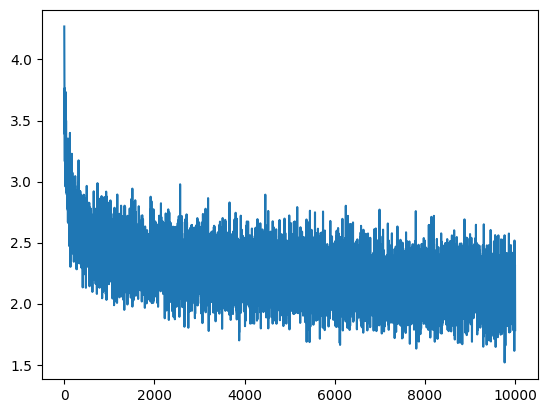

In [ ]:
model = TransformerDecoder(vocab_size, block_size, embed_size, num_heads, num_layers)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epoches = 10000
losses = []

def get_batch():
  ix = torch.randint(0, len(data) - block_size, (block_size,))
  x = [data[i:i+block_size].tolist() for i in ix]
  y = [data[i+1:i+1+block_size].tolist() for i in ix]
  return torch.tensor(x),torch.tensor(y)

def train():
  for i in range(num_epoches):
    x,y = get_batch()
    loss = model(x,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if i % 200 == 0:
      print(f'epoch {i}  loss:{loss.item()}')
train()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(losses)
plt.subplot(122)
plt.plot(torch.tensor(losses).view(-1,200).mean(-1))

In [ ]:
def generate():
  with torch.no_grad():
    context = torch.zeros((8,),dtype=torch.long).tolist()
    for _ in range(500):
      logits  = model(torch.tensor(context[-block_size:]))
      idx = torch.multinomial(logits, 1, replacement=True)
      context.append(idx[-1].item())
  print(decode(context[block_size:]))
generate()

ELaSTENTIO:
No lave. do were in briefan thushy,--
now, Prow!
AUMINTES:
On biedst?

Brayir fith, wher not now reaph in of that; rnown:
Theee tall wer a motirion swant of as the abuthat sheir thach in gie; thir whe Routh tat you know.

YORD he is thy leefied talle;
But, him hanke; she tremnct fife sorty Proandsters all the, hor fased
Sengresianked, milled
Ca, scouns you of spoliachend on, whosb hath this tembly work fatcmes,
I vifules, lais he tas we knot masin? andes, andatings, tas swhil, here h


In [ ]:
print([f'{p.data.shape}:{len(p.data)}' for p in model.parameters()])

['torch.Size([65, 64]):65', 'torch.Size([8, 64]):8', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([256, 64]):256', 'torch.Size([256]):256', 'torch.Size([64, 256]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([256, 64]):256', 'torch.Size([256]):256', 'torch.Size([64, 256]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([256, 64]):256', 'torch.Size([256]):256', 'torch.Size([64, 256]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([256, 64]):256', 'torch.Size([256]):256', 'torch.Size([64, 256]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([64]):64', 'torch.Size([65, 64]):65', 'torch.Size([65]):65']
